In [1]:
import pandas as pd
import numpy as np


def get_model_data(model_name: str):
    df = pd.read_parquet(f"../data/train_latent_{model_name}_scenario.parquet")
    df_test = pd.read_parquet(f"../data/test_latent_{model_name}_scenario.parquet")

    df["train"] = True
    df_test["train"] = False

    df = pd.concat([df, df_test], ignore_index=True)
    df_test = None

    n_activations_one = 8192
    def to_x_y(df: pd.DataFrame):
        
        r = df.shape[0]

        df["label"] = df["scenario_name"].astype("category").cat.codes
        
        mapping = df[["scenario_name", "label"]].drop_duplicates()
        mapping = mapping.set_index("label")
        mapping = mapping["scenario_name"].to_dict()

        print(mapping)

        X = np.full((r, n_activations_one * 2), np.nan, dtype=np.float16)
        y = df["label"].to_numpy()
        train = df["train"].to_numpy()
        
        col = df.columns.get_loc("features")

        for i in range(r):
            X[i, :] = df.iloc[i, col]

        return X, y, mapping, train


    X, y, mapping, train = to_x_y(df)
    return X, y, mapping, train


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from sklearn.metrics import precision_score, recall_score
import torch
from torch.utils.data import DataLoader, TensorDataset

class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, l1_lambda=0.01):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        self.l1_lambda = l1_lambda

    def forward(self, x):
        return self.softmax(self.linear(x))

    def compute_loss(self, outputs, targets):
        cross_entropy_loss = -torch.mean(torch.sum(targets * torch.log(outputs + 1e-8), dim=1))
        l1_loss = self.l1_lambda * torch.mean(torch.abs(self.linear.weight))
        return cross_entropy_loss + l1_loss


# class LinearClassifier(nn.Module):
#     def __init__(self, input_dim, output_dim, l1_lambda=0.01):
#         super(LinearClassifier, self).__init__()
#         self.raw_weight = nn.Parameter(torch.randn(output_dim, input_dim))  # Unconstrained parameter
#         self.bias = nn.Parameter(torch.zeros(output_dim))
#         self.softmax = nn.Softmax(dim=1)
#         self.l1_lambda = l1_lambda

#     def forward(self, x):
#         weight = F.softplus(self.raw_weight)  # Ensures non-negative weights
#         logits = F.linear(x, weight, self.bias)
#         return self.softmax(logits)

#     def compute_loss(self, outputs, targets):
#         cross_entropy_loss = -torch.mean(torch.sum(targets * torch.log(outputs + 1e-8), dim=1))
#         l1_loss = self.l1_lambda * torch.mean(torch.abs(F.softplus(self.raw_weight)))  # L1 regularization on positive weights
#         return cross_entropy_loss + l1_loss


def train_model(model, X, y, n_epochs=10, batch_size=32, validation_split=0.2, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    n_samples = X.shape[0]
    n_val = int(n_samples * validation_split)
    n_train = n_samples - n_val
    
    print(" val", n_val)

    indices = torch.randperm(n_samples)
    train_indices, val_indices = indices[:n_train], indices[n_train:]
    
    X_train, y_train = X[train_indices], y[train_indices]
    y_train_onehot = torch.nn.functional.one_hot(y_train, num_classes=3).float()
    train_dataset = TensorDataset(X_train, y_train_onehot)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    if validation_split > 0:
        X_val, y_val = X[val_indices], y[val_indices]
        y_val_onehot = torch.nn.functional.one_hot(y_val, num_classes=3).float()
        val_dataset = TensorDataset(X_val, y_val_onehot)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
    

    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, precisions, recalls = [], [], [], []
    
    for epoch in tqdm.tqdm(list(range(n_epochs))):
        model.train()
        train_loss_epoch = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = model.compute_loss(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()
        
        train_losses.append(train_loss_epoch / len(train_loader))
        
        if validation_split > 0:
            model.eval()
            val_loss_epoch = 0
            all_predictions = []
            all_targets = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    loss = model.compute_loss(outputs, y_batch)
                    val_loss_epoch += loss.item()
                    
                    predictions = torch.argmax(outputs, dim=1)
                    targets = torch.argmax(y_batch, dim=1)
                    all_predictions.extend(predictions.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
            
            val_losses.append(val_loss_epoch / len(val_loader))
            
            precision = precision_score(all_targets, all_predictions, average='macro', zero_division=np.nan)
            recall = recall_score(all_targets, all_predictions, average='macro', zero_division=np.nan)
            
            precisions.append(precision)
            recalls.append(recall)

        # print(train_losses[-1], val_losses[-1])
    
    return train_losses, val_losses, precisions, recalls


def inference(model: LinearClassifier, X: np.ndarray, batch_size: int) -> np.ndarray:

    X = torch.tensor(X, dtype=torch.float32)
   
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size)

    all_predictions = []

    for X_batch in loader:
        X_batch = X_batch[0]
        X_batch = X_batch.to("cuda")

        with torch.no_grad():
            outputs = model(X_batch)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())

    return np.array(all_predictions)

        

In [5]:
def linear_classifier_f1(X: np.ndarray, y: np.ndarray, validation_split: float =  0.2, n_epochs: int = 100):
    model = LinearClassifier(X.shape[1], np.unique(y).size, l1_lambda=10)

    tl, vl, pre, rec = train_model(model, X, y, n_epochs=n_epochs, batch_size=500, validation_split=validation_split, learning_rate=1e-3)

    return tl, vl, pre, rec

def eval_all_model() -> list[tuple[str, list[float]]]:
    
    model_names = ["checkpoint_05", "checkpoint_03", "checkpoint_1"]

    res = []

    for model in model_names:
        X, y, _, _ = get_model_data(model)
        f1 = linear_classifier_f1(X, y)
        res.append((model, f1))
        
    return res

res = eval_all_model()    

{1: 'pawn_promotion', 2: 'queen_loss', 0: 'knight_fork'}
 val 962


100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


{1: 'pawn_promotion', 2: 'queen_loss', 0: 'knight_fork'}
 val 962


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


{1: 'pawn_promotion', 2: 'queen_loss', 0: 'knight_fork'}
 val 962


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


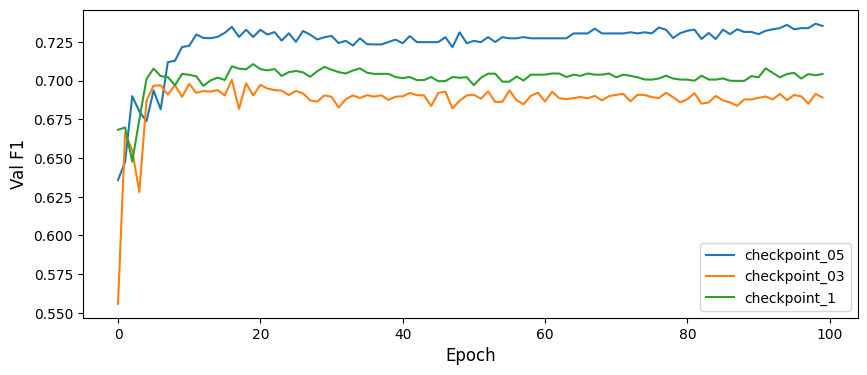

In [6]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

for name, (tl, vl, pre, rec) in res:

    pre = np.array(pre)
    rec = np.array(rec)

    f1 = 2 * (pre * rec) / (pre + rec)

    ax.plot(f1, label=name)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Val F1", fontsize=12)

ax.legend()
plt.show()

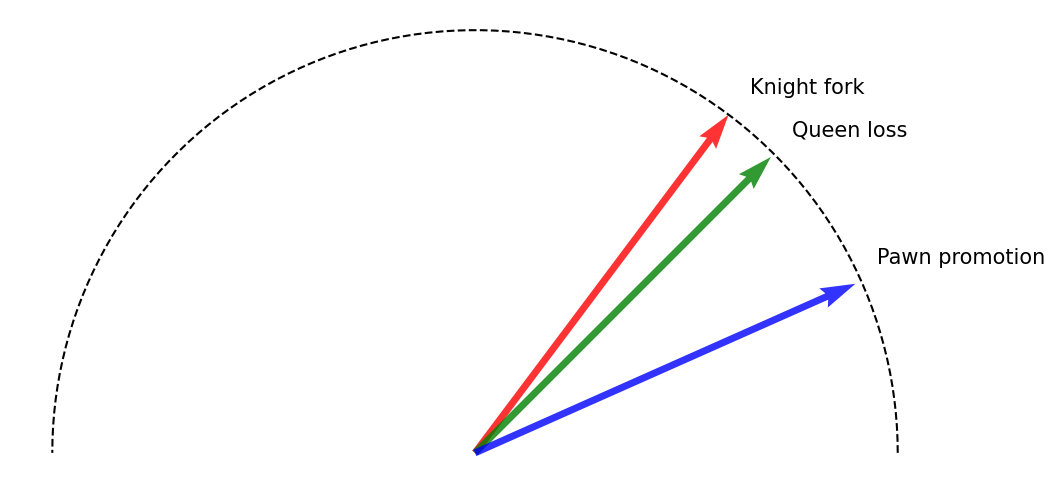

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define unit vectors
word_vectors = {
    "Knight fork": np.array([0.6, 0.8]),
    "Queen loss": np.array([0.7, 0.7]),
    "Pawn promotion": np.array([0.9, 0.4]),
}

# Origin for all vectors
origin = np.array([0, 0])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

color = ["red", "green", "blue"]

# Plot the word vectors using quiver
for i, (word, vec) in enumerate(word_vectors.items()):
    ax.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, alpha=0.8, color=color[i])
    ax.text(vec[0] + 0.05, vec[1] + 0.05, word, fontsize=15, color='black')

# Draw a half-circle to indicate unit vectors
theta = np.linspace(0, np.pi, 100)  # Half-circle
circle_x = np.cos(theta)
circle_y = np.sin(theta)
ax.plot(circle_x, circle_y, '--', linewidth=1.5, color="black")  # Dashed red half-circle

# Remove axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Set equal aspect ratio
# ax.set_xlim(-0.2, 1.2)
# ax.set_ylim(-0.2, 1.2)
ax.set_aspect('equal')

# Show the plot
plt.show()


### Best

In [20]:
X, y, mapping, _ = get_model_data("checkpoint_05")

{1: 'pawn_promotion', 2: 'queen_loss', 0: 'knight_fork'}


In [21]:
l, v = np.unique(y, return_counts=True)
l, v

(array([0, 1, 2], dtype=int8), array([ 482, 2058, 2274], dtype=int64))

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

model = LinearClassifier(X.shape[1], np.unique(y).size, l1_lambda=10)
_ = train_model(model, X_train, y_train, n_epochs=40, batch_size=500, validation_split=0)

 val 0


100%|██████████| 40/40 [00:07<00:00,  5.03it/s]


In [255]:
X_train.shape[0], X_test.shape[0]

(4332, 482)

In [27]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

yhat_test = inference(model, X_test, batch_size=200)
cm = confusion_matrix(y_test, yhat_test)
f1 = f1_score(y_test, yhat_test, average="macro")
prec = precision_score(y_test, yhat_test, average="macro")
reca = recall_score(y_test, yhat_test, average="macro")

print(cm)
print(f1, prec, reca)

[[ 18   9  21]
 [  3 178  25]
 [ 12  23 193]]
0.7089220459134805 0.7335349912755772 0.6951896326576961


random

In [251]:
print(f1_score(np.random.choice(3, size=10_000), np.random.choice(3, size=10_000), average="macro"))

0.3287033876704744


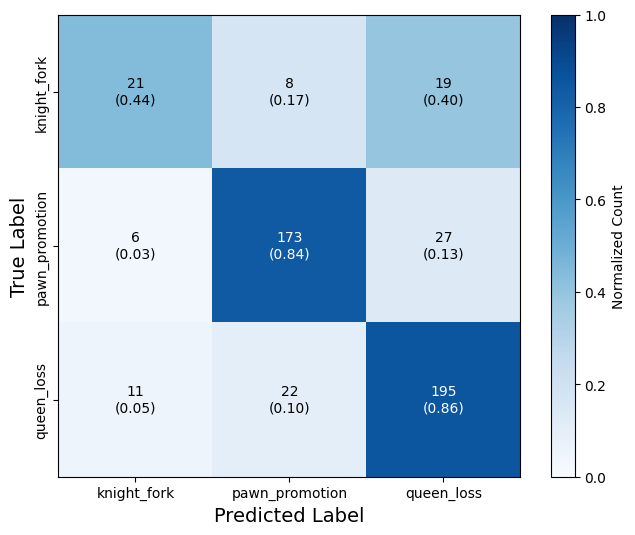

In [261]:
import numpy as np
import matplotlib.pyplot as plt

def show_confusion_matrix(cm: np.ndarray, mapping: dict[int, str]):
    original_cm = cm.copy()  # Keep the original counts for display
    cm = cm / np.sum(cm, axis=1, keepdims=True)  # Normalize
    
    keys = sorted(mapping.keys())
    ticks = [mapping[k] for k in keys]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=1)
    
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    ax.set_xticks(range(len(ticks)))
    ax.set_yticks(range(len(ticks)))
    ax.set_xticklabels(ticks, rotation=0, ha="center")
    ax.set_yticklabels(ticks, rotation=90, va="center")
    
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{original_cm[i, j]:.0f}\n({cm[i, j]:.2f})", ha='center', va='center',
                    color="black" if cm[i, j] < 0.5 else "white", fontsize=10)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Normalized Count")

    fig.savefig("./cm.pdf")    
    plt.show()


show_confusion_matrix(cm, mapping)

In [253]:
labels = ["knight_fork", "pawn_promotion", "queen_loss"]

In [29]:
coefficients = model.linear.weight.clone().detach().cpu().numpy().astype(np.float16)

In [30]:
(np.abs(coefficients) < 0.1).mean()

0.9982503255208334

In [35]:
def get_concept_vector(X: np.ndarray, coefficients: np.ndarray, concept: int):

    c = np.zeros_like(X)

    w = coefficients[concept, :]
    for i in range(X.shape[0]):
        c[i, :] = X[i, :] * w

    c = np.mean(c, axis=0)
    c = c / np.linalg.norm(c)

    return c


v_knight = get_concept_vector(X[y == 0], coefficients, 0)
v_pawn = get_concept_vector(X[y == 1], coefficients, 1)
v_queen = get_concept_vector(X[y == 2], coefficients, 2)

In [178]:
def split_common_diff(v: np.ndarray, norm: bool = False):
    m = v.shape[0] // 2
    c = np.full(m, np.nan)
    d = np.full(m, np.nan)

    c[:] = v[:m]
    d[:] = v[m:]

    if norm:
        c = c / np.linalg.norm(c)
        d = d / np.linalg.norm(d)

    return c, d

c_knight, d_knight = split_common_diff(v_knight, True)
c_pawn, d_pawn = split_common_diff(v_pawn, True)
c_queen, d_queen = split_common_diff(v_queen, True)

array([1.00000000e-01, 3.16227766e-02, 1.00000000e-02, 3.16227766e-03,
       1.00000000e-03, 3.16227766e-04, 1.00000000e-04, 3.16227766e-05])

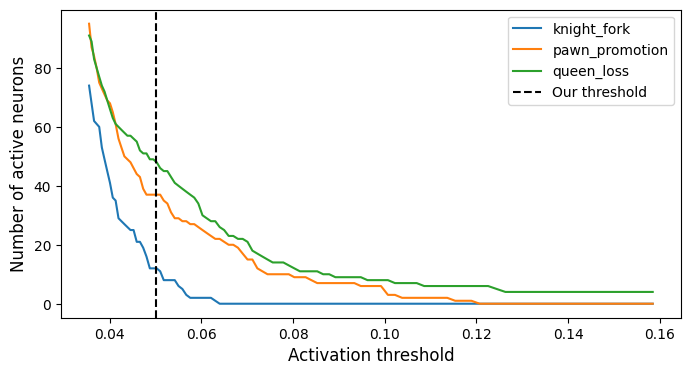

In [296]:
def gen_T_graph():
    
    fig, ax = plt.subplots(figsize=(8, 4))

    Ts = np.array(10) ** (-np.linspace(0.8, 1.45, num=100, dtype=float))
    k_sums = []
    p_sums = []
    q_sums = []

    for T in Ts:
        k_sums.append((v_knight > T).sum())
        p_sums.append((v_pawn > T).sum())
        q_sums.append((v_queen > T).sum())

    ax.plot(Ts, k_sums, label="knight_fork")
    ax.plot(Ts, p_sums, label="pawn_promotion")
    ax.plot(Ts, q_sums, label="queen_loss")
    ax.axvline(0.05, color="black", linestyle="dashed", label="Our threshold")

    # ax.set_xscale("log")
    ax.legend()
    ax.set_xlabel("Activation threshold", fontsize=12)
    ax.set_ylabel("Number of active neurons", fontsize=12)

    fig.savefig("./active.pdf")
    plt.show()


gen_T_graph()

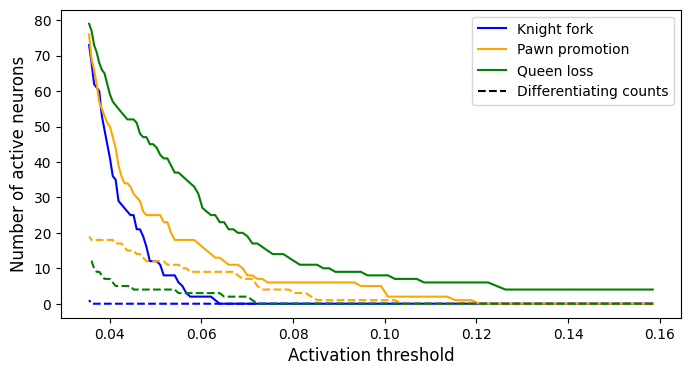

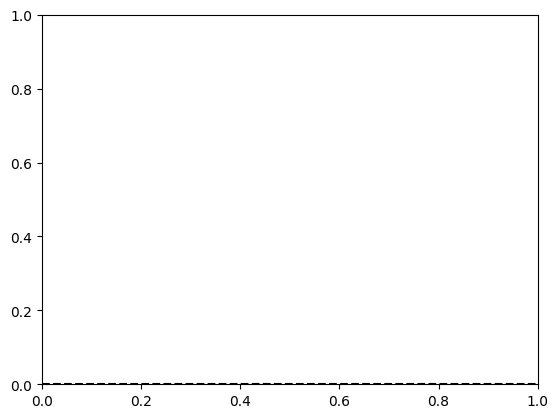

In [53]:
def gen_T_graph():
    
    fig, ax = plt.subplots(figsize=(8, 4))

    Ts = np.array(10) ** (-np.linspace(0.8, 1.45, num=100, dtype=float))
    k_sums = []
    p_sums = []
    q_sums = []

    def counts(T, v):
        mid = v.shape[0] // 2
        inds = np.where(v > T)[0]
        cc = (inds < mid).sum()
        dc = (inds >= mid).sum()
        return cc, dc

    for T in Ts:
        k_sums.append(counts(T, v_knight))
        p_sums.append(counts(T, v_pawn))
        q_sums.append(counts(T, v_queen))

    k_sums = np.array(k_sums)
    p_sums = np.array(p_sums)
    q_sums = np.array(q_sums)

    ax.plot(Ts, k_sums[:, 0], label="Knight fork", color="blue")
    ax.plot(Ts, p_sums[:, 0], label="Pawn promotion", color="orange")
    ax.plot(Ts, q_sums[:, 0], label="Queen loss", color="green")

    ax.plot(Ts, k_sums[:, 1], color="blue", linestyle="dashed")
    ax.plot(Ts, p_sums[:, 1], color="orange", linestyle="dashed")
    ax.plot(Ts, q_sums[:, 1], color="green", linestyle="dashed")

    plt.ioff()
    f, a = plt.subplots()
    a.axhline(0, color="black", linestyle="dashed", label="Differentiating counts")
    ht, lt = a.get_legend_handles_labels()


    h, l = ax.get_legend_handles_labels()
    
    # ax.set_xscale("log")
    ax.legend(h + ht, l + lt)
    ax.set_xlabel("Activation threshold", fontsize=12)
    ax.set_ylabel("Number of active neurons", fontsize=12)

    plt.show()


gen_T_graph()

In [294]:
def latent_summary(v: np.ndarray, T: float = 0.05):
    m  = v.shape[0] // 2
    indicies = np.where(v > T)[0]
    
    neurons = indicies.size
    common = (indicies < m).sum()
    diff = (indicies >= m).sum()
    print(f"All {neurons}, common {common}, diff {diff}")

    return set(indicies)

In [299]:
16 * 2 * 128 

4096

In [249]:
X.shape

(4814, 16384)

In [248]:
coefficients.shape

(3, 16384)

In [297]:
l_knight = latent_summary(v_knight)

All 12, common 12, diff 0


In [244]:
l_queen = latent_summary(v_queen)

All 49, common 45, diff 4


In [245]:
l_pawn = latent_summary(v_pawn)

All 37, common 25, diff 12


In [36]:
def cdist(x1, x2):
    return 1 - np.dot(x1, x2)

cdist(v_knight, v_queen), cdist(v_knight, v_pawn), cdist(v_queen, v_pawn)

(0.18212890625, 0.255859375, 0.345703125)

In [241]:
p_shared = len(l_knight & l_queen) / len(l_knight | l_queen), len(l_knight & l_pawn) / len(l_knight | l_pawn), len(l_queen & l_pawn) / len(l_queen | l_pawn)
print(f"knight queen {p_shared[0] * 100:.2f}%")
print(f"knight pawn {p_shared[1] * 100:.2f}%")
print(f"pawn queen {p_shared[2] * 100:.2f}%")

knight queen 9.09%
knight pawn 1.87%
pawn queen 3.05%
